In [2]:
import string
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('/content/drive/MyDrive/MachineLearningClass/names-gen-data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Polish', 'Irish', 'Russian', 'Korean', 'Chinese', 'Italian', 'Portuguese', 'Spanish', 'French', 'Czech', 'Greek', 'Scottish', 'Arabic', 'Japanese', 'German', 'Dutch', 'English', 'Vietnamese']
O'Neal


In [73]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])
torch.Size([5, 1, 59])


In [4]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Irish / line = Manus
category = French / line = Leveque
category = Scottish / line = Bell
category = Korean / line = Ron
category = Czech / line = Ponec
category = French / line = Lebeau
category = Russian / line = Hanok
category = Polish / line = Auttenberg
category = English / line = Boyd
category = Polish / line = Kijek


In [5]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [6]:
from torch.nn.utils.rnn import pad_sequence
import torch

def randomTrainingBatch(batch_size):
    categories, lines, category_tensors, line_tensors = [], [], [], []
    lengths = []  # List to store the lengths of sequences

    for _ in range(batch_size):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        categories.append(category)
        lines.append(line)
        category_tensors.append(category_tensor)
        line_tensors.append(line_tensor)
        lengths.append(len(line_tensor))  # Append the length of this line tensor

    # Pad the sequences so they all have the same length
    line_tensors = pad_sequence(line_tensors, batch_first=True, padding_value=0)  # Adjust padding_value as needed

    # Stack category tensors if they do not require padding
    category_tensors = torch.stack(category_tensors)

    # Create a mask for use in loss calculation
    max_length = line_tensors.size(1)
    mask = torch.zeros(batch_size, max_length)
    for i, length in enumerate(lengths):
        mask[i, :length] = 1

    return categories, lines, category_tensors, line_tensors, torch.tensor(lengths), mask



In [70]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size) # Ax=y, x: 5x1, y:3x1, A: 3x5
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        #print(output)
        output = self.softmax(output)
        return output, hidden

In [83]:
import torch.nn.functional as F

batch_size = 4
n_hidden = 64
learning_rate = 0.0001
num_iter = 10000

model = RNN(n_letters, n_hidden, n_letters)
criterion = nn.NLLLoss(reduction="none")

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

all_losses = []

for iter in range(num_iter):
  categories, lines, category_tensors, line_tensors, lengths, mask = randomTrainingBatch(batch_size)
  hidden = torch.zeros(batch_size, n_hidden)

  # line_tensors : batch_size x name-length x 1 x num_letters
  # category_tensors: batch_size x 1

  # convert category tensors into one-of-K format
  category_tensors = F.one_hot(category_tensors.squeeze(1), num_classes=18)

  loss = 0

  for i in range(line_tensors.size()[1]-1):
      output, hidden = model(category_tensors, line_tensors[:, i, :, :].squeeze(1), hidden)

      class_indices = torch.argmax(line_tensors[:, i + 1, :, :].squeeze(1), dim=1)


      l = criterion(output, class_indices)
      l = (l * mask[:, i]).sum() / mask[:, i].sum()

      loss += l

  if iter % 100 == 0:
    all_losses.append(loss.item())
    print('(%d %d%%) %.4f', iter, iter / num_iter * 100, loss)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()



(%d %d%%) %.4f 0 0.0 tensor(36.6029, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 100 1.0 tensor(27.5920, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 200 2.0 tensor(19.4096, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 300 3.0 tensor(25.1671, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 400 4.0 tensor(28.5505, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 500 5.0 tensor(41.1550, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 600 6.0 tensor(29.4346, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 700 7.000000000000001 tensor(24.2995, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 800 8.0 tensor(30.0102, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 900 9.0 tensor(20.2222, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 1000 10.0 tensor(17.6865, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 1100 11.0 tensor(21.7685, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 1200 12.0 tensor(15.5608, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 1300 13.0 tensor(15.9267, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 1400 14.000000000000002 tensor(18.1788, grad_fn=<AddBackward0>)
(%d %d%%) %.4f 1500

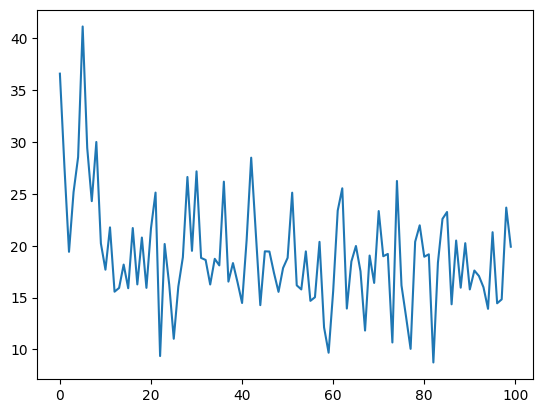

In [84]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)